# Bayesian Hilbert Maps

##### Email the authors to get the latest (much faster) code.

In [1]:
import numpy as np
import pandas as pd
import sbhm
import matplotlib.pyplot as pl
%matplotlib inline

Training data (pre-processed) file format:

    Column 0: Time step (0,1,2,3,...)
    Column 1: Logitide x1 
    Column 2: Latitude x2
    Column 3: Class labels (0 or 1)
    
$N$ data points (rows).

In [2]:
def load_parameters(case):
    parameters = \
        {'gilad2': \
             ('Dataset/gilad2.csv',
              (5, 5), #x1 and x2 resolutions for positioning hinge points
              (-300, 300, 0, 300), #area to be mapped [x1_min, x1_max, x2_min, x2_max]
              1, #N/A
              0.3, #threshold for filtering data
              0.075 #gamma: kernel parameter
              ),
         
         'intel': \
             ('Dataset/intel.csv',
              (0.5, 0.5), #x1 and x2 resolutions for positioning hinge points
              (-20, 20, -25, 10), #area to be mapped [x1_min, x1_max, x2_min, x2_max]
              1, #N/A
              0.01, #threshold for filtering data
              6.71 #gamma: kernel parameter
            ),

        }

    return parameters[case]

shapes: (383118, 4)


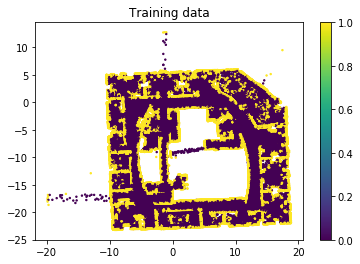

In [3]:
fn_train, cell_resolution, cell_max_min, skip, thresh, gamma = load_parameters('intel')

#read data
g = pd.read_csv(fn_train, delimiter=',').values
print('shapes:', g.shape)
X_train = np.float_(g[:, 0:3])
Y_train = np.float_(g[:, 3][:, np.newaxis]).ravel() #* 2 - 1

pl.figure()
pl.scatter(X_train[:,1], X_train[:,2], c=Y_train, s=2)
pl.title('Training data')
pl.colorbar()
pl.show()

#query locations
q_resolution = 0.5
xx, yy = np.meshgrid(np.arange(cell_max_min[0], cell_max_min[1]-1, q_resolution), np.arange(cell_max_min[2], cell_max_min[3]-1, q_resolution))
X_query = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))

If there are N data points (rows),

    X_train.shape = (N,3) #the three columns are (time_step, logitude, latitude)
    Y_train.shape = (N,) #labels are either 0 or 1
    
If we want to query the occupancy probability of N_q positions (rows),

    X_query.shape = (N_q,2) #the two columns are (logitude, latitude)

0th scan:
  N=380
D= 5600
1th scan:
  N=388
  97.94% points were used.
2th scan:
  N=390
  99.74% points were used.
3th scan:
  N=414
  100.00% points were used.


KeyboardInterrupt: 

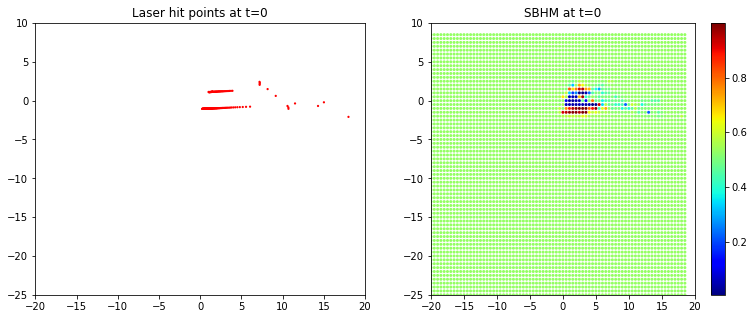

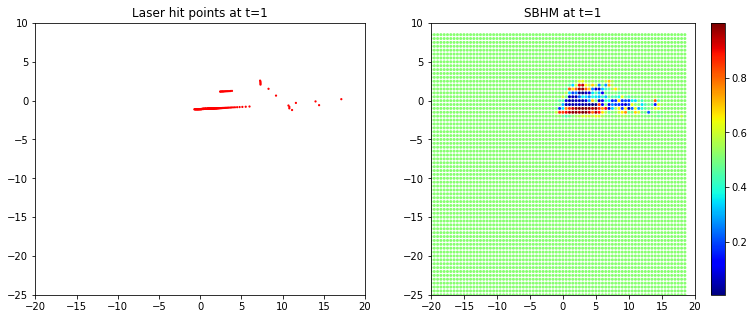

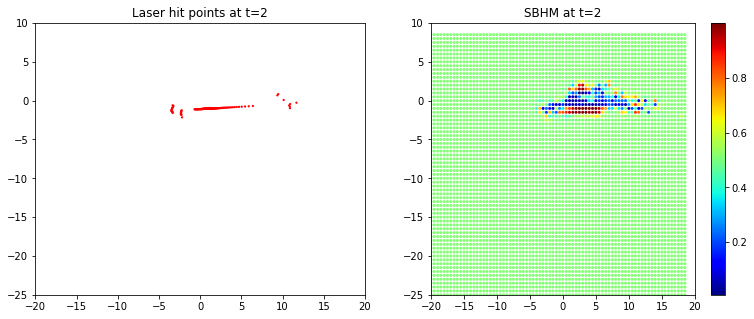

In [4]:
max_t = len(np.unique(X_train[:, 0]))
for ith_scan in range(0, max_t, skip): 

    # extract data points of the ith scan
    ith_scan_indx = X_train[:, 0] == ith_scan
    print('{}th scan:\n  N={}'.format(ith_scan, np.sum(ith_scan_indx)))
    X_new = X_train[ith_scan_indx, 1:]
    y_new = Y_train[ith_scan_indx]

    if ith_scan == 0:
        # get all data for the first scan and initialize the model
        X, y = X_new, y_new
        bhm_mdl = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=X, calc_loss=False)
    else:
        # information filtering
        q_new = bhm_mdl.predict_proba(X_new)[:, 1]
        info_val_indx = np.absolute(q_new - y_new) > thresh
        X, y = X_new[info_val_indx, :], y_new[info_val_indx]
        print('  {:.2f}% points were used.'.format(X.shape[0]/X_new.shape[0]*100))
    
    #training
    bhm_mdl.fit(X, y)
    
    #query the model
    Y_query = bhm_mdl.predict_proba(X_query)[:,1]
    
    #plot
    pl.figure(figsize=(13,5))
    pl.subplot(121)
    ones_ = np.where(y==1)
    pl.scatter(X[ones_, 0], X[ones_, 1], c='r', cmap='jet', s=5, edgecolors='')
    pl.title('Laser hit points at t={}'.format(ith_scan))
    pl.xlim([cell_max_min[0], cell_max_min[1]]); pl.ylim([cell_max_min[2], cell_max_min[3]])
    pl.subplot(122)
    pl.title('SBHM at t={}'.format(ith_scan))
    pl.scatter(X_query[:, 0], X_query[:, 1], c=Y_query, cmap='jet', s=10, marker='8',edgecolors='')
    #pl.imshow(Y_query.reshape(xx.shape))
    pl.colorbar()
    pl.xlim([cell_max_min[0], cell_max_min[1]]); pl.ylim([cell_max_min[2], cell_max_min[3]])
    pl.savefig('Output/step' + str(ith_scan) + '.png', bbox_inches='tight')
    #pl.show()
    #pl.close("all")